In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import keras
import keras.preprocessing.image

import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
keras.backend.tensorflow_backend.set_session(get_session())

from keras_retinanet.models.resnet import custom_objects
#from keras_retinanet.preprocessing.coco import CocoGenerator
from keras_retinanet.preprocessing.url_generator import UrlGenerator

/Users/xpitfire/anaconda3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load RetinaNet model

In [2]:
model_name = 'snapshots/resnet50_coco_best_v2.0.1.h5'
#model_name = 'snapshots/resnet50_coco_05.h5'

model = keras.models.load_model(model_name, custom_objects=custom_objects)

/Users/xpitfire/anaconda3/lib/python3.5/site-packages/keras/models.py:274: UserWarning: Output "nms" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "nms" during training.
  sample_weight_mode=sample_weight_mode)


In [3]:
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
padding_conv1 (ZeroPadding2D)   (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9408        padding_conv1[0][0]              
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu

## Initialize data generators

In [ ]:
# create image data generator object
val_image_data_generator = keras.preprocessing.image.ImageDataGenerator()

# create a generator for testing data
val_generator = CocoGenerator(
    'C:\\Users\\celum\\source\\data',
    'val2017'
)

## Run detection on validation example

In [ ]:
index = 0

In [ ]:
# load image
image = val_generator.load_image(index)

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = val_generator.preprocess_image(image)
image, scale = val_generator.resize_image(image)
annotations = val_generator.load_annotations(index)
index += 1

# process image
start = time.time()
_, _, detections = model.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

# compute predicted labels and scores
predicted_labels = np.argmax(detections[0, :, 4:], axis=1)
scores = detections[0, np.arange(detections.shape[1]), 4 + predicted_labels]

# correct for image scale
detections[0, :, :4] /= scale

# visualize detections
for idx, (label, score) in enumerate(zip(predicted_labels, scores)):
    if score < 0.5:
        continue
    b = detections[0, idx, :4].astype(int)
    cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 3)
    caption = "{} {:.3f}".format(val_generator.label_to_name(label), score)
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 3)
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)
    
# visualize annotations
for annotation in annotations:
    label = int(annotation[4])
    b = annotation[:4].astype(int)
    cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 255, 0), 2)
    caption = "{}".format(val_generator.label_to_name(label))
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 3)
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)
    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()

## Run detection on custom image

In [4]:
# create image data generator object
val_image_data_generator = keras.preprocessing.image.ImageDataGenerator()

In [5]:
urls = [
    'https://www.travellers-insight.com/wp-content/uploads/2017/05/Travellers-Insight-Reiseblog-Tokio-Highlights-Shibuya.jpg',
    #'https://i.stack.imgur.com/H03KE.png',
    #'https://upload.wikimedia.org/wikipedia/commons/thumb/f/f3/Pilies_Street_at_dusk%2C_Vilnius%2C_Lithuania_-_Diliff.jpg/1200px-Pilies_Street_at_dusk%2C_Vilnius%2C_Lithuania_-_Diliff.jpg',
    #'http://idolza.com/a/f/t/the-office-desk-guide-gentlemans-gazette-credenza_office-desk-modern_interior-design-firms-home-office-ideas-your-house-modern-floor-plans-contemporary-room-architecture-and.jpg',
    #'http://www.socialjin.com/wp-content/uploads/2016/05/88762487_junk_food.jpg',
    #'https://www.celum.com/cache/teaser/640x640-hero-celum-gruppenfoto-karrier.jpg'
]
classes_path = './data/coco/classes.json'
labels_path = './data/coco/labels.json'

In [6]:
# create a generator for testing data
val_generator = UrlGenerator(urls, classes_path, labels_path)

processing time:  6.200419902801514
(1, 181503, 84)


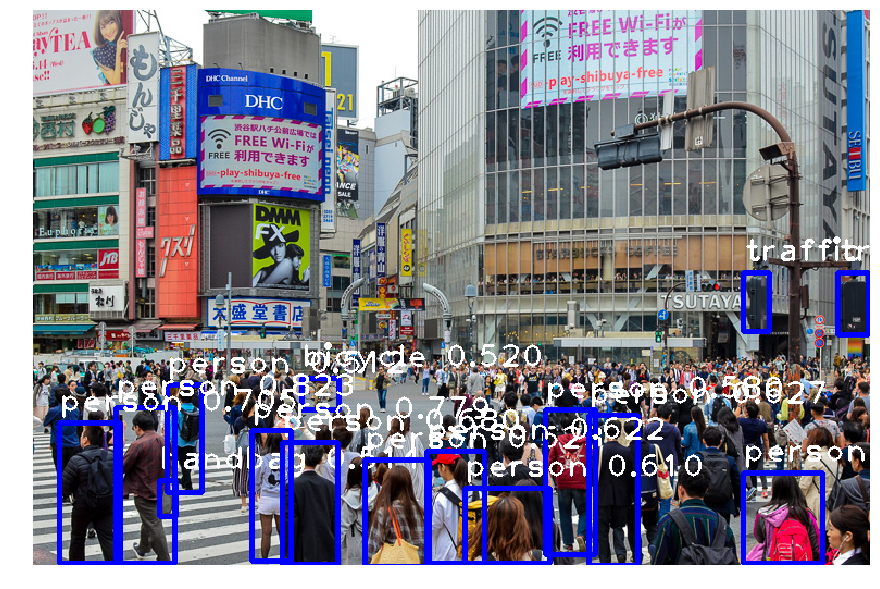

In [8]:
# load image
for i in range(len(urls)):
    image = val_generator.read_image_bgr(i)

    # copy to draw on
    draw = np.asarray(image.copy())
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    # preprocess image for network
    image = val_generator.preprocess_image(image)
    image, scale = val_generator.resize_image(image)

    # process image
    start = time.time()
    _, _, detections = model.predict_on_batch(np.expand_dims(image, axis=0))
    print("processing time: ", time.time() - start)
    print(detections.shape)

    # compute predicted labels and scores
    predicted_labels = np.argmax(detections[0, :, 4:], axis=1)
    scores = detections[0, np.arange(detections.shape[1]), 4 + predicted_labels]

    # correct for image scale
    detections[0, :, :4] /= scale

    # visualize detections
    for idx, (label, score) in enumerate(zip(predicted_labels, scores)):
        if score < 0.5:
            continue
        b = detections[0, idx, :4].astype(int)
        cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 3)
        caption = "{} {:.3f}".format(val_generator.label_to_name(label), score)
        cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 0), 2)
        cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 2, (255, 255, 255), 2)

    plt.figure(figsize=(15, 15))
    plt.axis('off')
    plt.imshow(draw)
    plt.show()